Using a simple architecture, **LeNet**, and acheiving an accuracy of **~97%**.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

import matplotlib.pyplot as plt
import numpy as np
import pathlib
import os

import copy
import random
import time

In [2]:
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
path = '/kaggle/input/rice-image-dataset/Rice_Image_Dataset/'

In [4]:
data_dir = pathlib.Path(path)
data_dir

PosixPath('/kaggle/input/rice-image-dataset/Rice_Image_Dataset')

Choosing only top images from each classification to visualize

In [5]:
arborio = list(data_dir.glob('Arborio/*'))[:1]
basmati = list(data_dir.glob('Basmati/*'))[:1]
ipsala = list(data_dir.glob('Ipsala/*'))[:1]
jasmine = list(data_dir.glob('Jasmine/*'))[:1]
karacadag = list(data_dir.glob('Karacadag/*'))[:1]

# **Visualization**

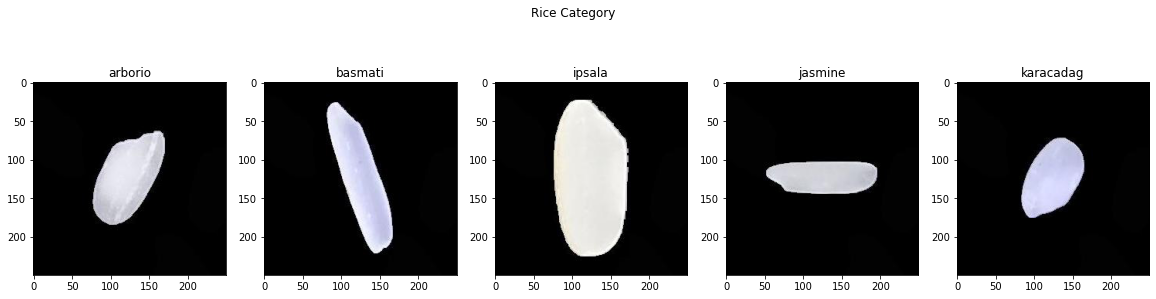

In [6]:
import matplotlib.image as img
fig, ax = plt.subplots(ncols = 5, figsize = (20,5))
fig.suptitle('Rice Category')
arborio_image = img.imread(arborio[0])
basmati_image = img.imread(basmati[0])
ipsala_image = img.imread(ipsala[0])
jasmine_image = img.imread(jasmine[0])
karacadag_image = img.imread(karacadag[0])

ax[0].set_title('arborio')
ax[1].set_title('basmati')
ax[2].set_title('ipsala')
ax[3].set_title('jasmine')
ax[4].set_title('karacadag')

ax[0].imshow(arborio_image)
ax[1].imshow(basmati_image)
ax[2].imshow(ipsala_image)
ax[3].imshow(jasmine_image)
ax[4].imshow(karacadag_image)

plt.show()

In [7]:
df_labels = {
    'Arborio' : 0,
    'Basmati' : 1,
    'Ipsala' : 2,
    'Jasmine' : 3,
    'Karacadag': 4
}
    

Joining the base directory and class images directory

In [8]:
class_names = ['Karacadag', 'Basmati', 'Jasmine', 'Arborio', 'Ipsala']
num_class = len(class_names)

image_files = [[os.path.join(path, class_name, x) for x in os.listdir(os.path.join(path, class_name))] for class_name in class_names]

Joining all the classes and creating a common dataset

In [9]:
images_paths = []
for i in range(5):
    for j in range(len(image_files[i])):
        current = image_files[i]
        images_paths.append(current[j])

Randomly suffling the images and creating train,validation and test sets. Other splitting methods can also be explored

In [10]:
import random

random.shuffle(images_paths)

train_paths = images_paths[:60000]
test_paths = images_paths[60000:70000]
valid_paths = images_paths[70000:]

In [11]:
import torchvision.transforms as transforms

Converting the image of **(250, 250)** pixels to **(256, 256)** simple calculations and flexibility in Model architecture.

In [12]:
transformations = transforms.Compose(
    [
        transforms.Resize((256,256)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize((0.5),(0.5))
    ]
)


In [13]:
from torch.utils.data import Dataset
from random import randint
from PIL import Image
class ImageDataset(Dataset):
    def __init__(self, df_labels, base_dir, transform=None):
        super().__init__()
    
        self.base_dir = base_dir
        self.df_labels = df_labels
        self.transform = transform
        
    def __len__(self):
        return len(self.base_dir)
    
    def __getitem__(self, index):
        
        image_path = self.base_dir[index]
        
        image = Image.open(image_path)
        
        label_name = image_path.split('/')[-2]
        
        label = self.df_labels[label_name]
        
        if self.transform is not None:
            image = self.transform(image)
        return (image, label)

The above class returns tensor image data and corresponding label based on the path.

In [14]:
train_data = ImageDataset(df_labels, train_paths, transformations)
test_data = ImageDataset(df_labels, test_paths, transformations)
valid_data = ImageDataset(df_labels, valid_paths, transformations)

In [15]:
from torch.utils.data import DataLoader
train_ds = DataLoader(train_data, batch_size = 64, shuffle = True)
val_ds = DataLoader(valid_data, batch_size = 64, shuffle = True)
test_ds = DataLoader(test_data, batch_size = 64, shuffle = True)

# **Model Creation**

In [16]:
class LeNet(nn.Module):
    def __init__(self, output_dim):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=3,
                               out_channels=6,
                               kernel_size=5)

        self.conv2 = nn.Conv2d(in_channels=6,
                               out_channels=16,
                               kernel_size=5)

        self.fc_1 = nn.Linear(16 * 61 * 61, 120)
        self.fc_2 = nn.Linear(120, 84)
        self.fc_3 = nn.Linear(84, output_dim)

    def forward(self, x):
        #(3, 256, 256) ---> input
        x = self.conv1(x) 
        #(6, 252, 252) ---> output
        x = F.max_pool2d(x, kernel_size=2)
        #(6, 126, 126)
        x = F.relu(x)
        x = self.conv2(x)
        #(16, 122, 122)
        x = F.max_pool2d(x, kernel_size=2)
        #(16, 61, 61)
        x = F.relu(x)
        x = x.view(x.shape[0], -1)
        h = x
        x = self.fc_1(x)
        x = F.relu(x)
        x = self.fc_2(x)
        x = F.relu(x)
        x = self.fc_3(x)
        return x, h

In [17]:
OUTPUT_DIM = 5
model = LeNet(OUTPUT_DIM)

In [18]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f'The model has {count_parameters(model):,} trainable parameters')


The model has 7,157,901 trainable parameters


In [19]:
# from graphviz import Digraph
# from torchviz import make_dot

# #x=Variable(torch.randn(batch_size,1,2,num_samples))
# x = torch.randn(100, 3, 32, 32).requires_grad_(True)
# y = model(x)
# make_dot(y, params=dict(list(model.named_parameters())))

The above code is to visualize at the architecture blocks using torchviz

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [21]:
model = model.to(device)

In [22]:
from torch.optim import Adam 

In [23]:
optimizer = Adam(model.parameters(), lr = 0.0001)
loss_fun = F.cross_entropy

# **Training & Evaluation**

In [24]:
def train(model, epoch, train_ds):
    model.train()
    total_num = len(train_ds.dataset)
    train_loss = 0
    correct_num = 0

    for image, label in train_ds:
        image = image.to(device)
        label = label.to(device)
        # Convert the tag from int32 type to long type, otherwise the calculation loss will report an error
        label = label.to(torch.long)

        output,_ = model(image)
        loss = loss_fun(output, label)
        train_loss += loss.item() * label.size(0)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        predict = torch.argmax(output, dim=-1)
        correct_num += label.eq(predict).sum()

    train_loss = train_loss / total_num
    train_acc = correct_num / total_num
    print('epoch: {} --> train_loss: {:.6f} - train_acc: {:.6f} - '.format(
        epoch, train_loss, train_acc), end='')
    
    
def evaluate(model, eval_ds, mode='val'):
    model.eval()

    total_num = len(eval_ds.dataset)
    eval_loss = 0
    correct_num = 0

    for image, label in eval_ds:
        image = image.to(device)
        label = label.to(device)
        label = label.to(torch.long)
        
        output,_ = model(image)
        loss = loss_fun(output, label)
        eval_loss += loss.item() * label.size(0)

        predict = torch.argmax(output, dim=-1)
        correct_num += label.eq(predict).sum()
    
    eval_loss = eval_loss / total_num
    eval_acc = correct_num / total_num
    
    print('{}_loss: {:.6f} - {}_acc: {:.6f}'.format(
        mode, eval_loss, mode, eval_acc))

Change the range for improved accuracy

In [25]:
for epoch in range(5):
    train(model, epoch, train_ds)
    evaluate(model, val_ds)

epoch: 0 --> train_loss: 0.194060 - train_acc: 0.934067 - val_loss: 0.077851 - val_acc: 0.971000
epoch: 1 --> train_loss: 0.084139 - train_acc: 0.969883 - val_loss: 0.097988 - val_acc: 0.963400
epoch: 2 --> train_loss: 0.073184 - train_acc: 0.974283 - val_loss: 0.073378 - val_acc: 0.974000
epoch: 3 --> train_loss: 0.061518 - train_acc: 0.978517 - val_loss: 0.065428 - val_acc: 0.977800
epoch: 4 --> train_loss: 0.049778 - train_acc: 0.982733 - val_loss: 0.040746 - val_acc: 0.986400


In [26]:
evaluate(model, test_ds, mode='test')

test_loss: 0.046363 - test_acc: 0.984000


Achieved an accuracy of ~97% using simple model and less number of epochs. Further improvements like learning rate optimizer, classification report can also be included. 
Any suggestions or improvements over this is highly appreciated.